<a href="https://colab.research.google.com/github/Untick/IrisID_gr1/blob/Andrey-Shalunov-folder/Andrey%20Shalunov/%D0%A1%D1%82%D0%B0%D0%B6%D0%B8%D1%80%D0%BE%D0%B2%D0%BA%D0%B0_ImageDataGen_98_(89_%D0%BA%D0%BB%D0%B0%D1%81%D1%81%D0%BE%D0%B2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Импортируем необходимые библиотеки

In [1]:
# Сеть прямого распространения
from tensorflow.keras.models import Sequential 

# Базовые слои для свёрточных сетей
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization

# Работа с изображениями
from tensorflow.keras.preprocessing.image import ImageDataGenerator 

# Оптимизаторы
from tensorflow.keras.optimizers import Adam     

# Используем для to_categoricall
from tensorflow.keras import utils               

# Для отрисовки изображений
from tensorflow.keras.preprocessing import image 

from tensorflow.keras.callbacks import ModelCheckpoint

# Матрица ошибок классификатора
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# для разделения выборок
from sklearn.model_selection import train_test_split

# Библиотека работы с массивами
import numpy as np

# Для отрисовки графиков
import matplotlib.pyplot as plt                  

# Для отрисовки изображений
from PIL import Image, ImageEnhance                       

# Для генерации случайных чисел 
import random                                    

# Для округления
import math                                      

# Для работы с файлами 
import os
import shutil
import zipfile     

# модуль для отсчета времени
import time                                   

# импорт tensorflow
import tensorflow as tf
# Для работы с файлами
import gc

import gdown

import numpy as np
import cv2
from scipy import ndimage
import math
import random

from google.colab.patches import cv2_imshow
from google.colab import drive

# Подключаемся к диску

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


# Определим пути до папок

In [4]:
output_path = '/content/IrisDataSource/patients/'
result_path = '/content/IrisDataSource/patients_flat/'
TRAIN_PATH = '/content/IrisDataSource/patients_flat/categorical/'

In [3]:
!rm -rf /content/IrisDataSource
!mkdir /content/IrisDataSource/
!mkdir /content/IrisDataSource/patients_flat
!mkdir /content/IrisDataSource/patients_flat/categorical/

In [5]:
!cp -r '/content/drive/MyDrive/IrisDataSource_flat_new/.' '/content/IrisDataSource/patients_flat' 

# Классифицируем изображения

In [6]:
# Получаем список всех файлов в папке и ее подпапках
file_list = []
for root, dirs, files in os.walk(result_path):
    for file in files:
        file_list.append(os.path.join(root, file))

# Итерируемся по всем файлам и извлекаем числа из имен файлов
labels = []    
iris_images = []  

for file_path in file_list:
    # Получаем имя файла без расширения
    filename = os.path.splitext(os.path.basename(file_path))[0]
    fileext = os.path.splitext(os.path.basename(file_path))[1]
    # Получаем первые три числа из имени файла и убираем ведущие нули
    patient_num = int(''.join(filter(str.isdigit, filename))[:3])
    iris_images.append(filename+fileext)
    labels.append(patient_num)
    new_file_path = f'{TRAIN_PATH}{patient_num}'
    if not os.path.exists(new_file_path):
      os.mkdir(new_file_path)
    os.rename(f'{file_path}', f'{new_file_path}/{filename+fileext}')


# Определим параметры аугментации

In [7]:
TEST_PATH           = '/content/IrisDataSource/test/'  # Папка для тестового набора данных

TEST_SPLIT          = 0.2                   # Доля тестовых данных в общем наборе
VAL_SPLIT           = 0.2                   # Доля проверочной выборки в обучающем наборе

IMG_WIDTH           = 350                   # Ширина изображения для нейросети
IMG_HEIGHT          = 100                   # Высота изображения для нейросети
IMG_CHANNELS        = 3                     # Количество каналов (для RGB равно 3, для Grey равно 1)

# Параметры аугментации
ROTATION_RANGE      = 2                     # Пределы поворота
WIDTH_SHIFT_RANGE   = 10                    # Пределы сдвига по горизонтали
HEIGHT_SHIFT_RANGE  = 10                    # Пределы сдвига по вертикали
ZOOM_RANGE          = 0.08                  # Пределы увеличения/уменьшения
BRIGHTNESS_RANGE    = (0.8, 1.2)            # Пределы изменения яркости
HORIZONTAL_FLIP     = False                 # Горизонтальное отражение разрешено

EPOCHS              = 350                   # Число эпох обучения
BATCH_SIZE          = 32                     # Размер батча для обучения модели
OPTIMIZER           = Adam(0.00001)          # Оптимизатор
     

In [8]:
# Определение списка имен классов
CLASS_LIST = sorted(os.listdir(TRAIN_PATH))

# Определение количества классов
CLASS_COUNT = len(CLASS_LIST)

# Проверка результата
print(f'Количество классов: {CLASS_COUNT}, метки классов: {CLASS_LIST}')

Количество классов: 89, метки классов: ['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '6', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '7', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '8', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '9']


In [9]:
os.mkdir(TEST_PATH)                                        # Создание папки для тестовых данных
train_count = 0
test_count = 0

for class_name in CLASS_LIST:                              # Для всех классов по порядку номеров (их меток)
    class_path = f'{TRAIN_PATH}/{class_name}'              # Формирование полного пути к папке с изображениями класса
    test_path = f'{TEST_PATH}/{class_name}'                # Полный путь для тестовых данных класса
    class_files = os.listdir(class_path)                   # Получение списка имен файлов с изображениями текущего класса
    class_file_count = len(class_files)                    # Получение общего числа файлов класса
    os.mkdir(test_path)                                    # Создание подпапки класса для тестовых данных
    test_file_count = int(class_file_count * TEST_SPLIT)   # Определение числа тестовых файлов для класса
    test_files = class_files[-test_file_count:]            # Выделение файлов для теста от конца списка
    print(test_files)
    for f in test_files:                                   # Перемещение тестовых файлов в папку для теста
        os.rename(f'{class_path}/{f}', f'{test_path}/{f}')
    train_count += class_file_count                        # Увеличение общего счетчика файлов обучающего набора
    test_count += test_file_count                          # Увеличение общего счетчика файлов тестового набора

    print(f'Размер класса {class_name}: {class_file_count} пациентов, для теста выделено файлов: {test_file_count}')

print(f'Общий размер базы: {train_count}, выделено для обучения: {train_count - test_count}, для теста: {test_count}')

['001L_2.png']
Размер класса 1: 6 пациентов, для теста выделено файлов: 1
['010R_1.png']
Размер класса 10: 6 пациентов, для теста выделено файлов: 1
['011L_2.png']
Размер класса 11: 6 пациентов, для теста выделено файлов: 1
['012L_2.png']
Размер класса 12: 6 пациентов, для теста выделено файлов: 1
['013L_3.png']
Размер класса 13: 6 пациентов, для теста выделено файлов: 1
['014R_3.png']
Размер класса 14: 6 пациентов, для теста выделено файлов: 1
['015R_3.png']
Размер класса 15: 6 пациентов, для теста выделено файлов: 1
['016R_2.png']
Размер класса 16: 6 пациентов, для теста выделено файлов: 1
['017R_1.png']
Размер класса 17: 6 пациентов, для теста выделено файлов: 1
['018L_2.png']
Размер класса 18: 6 пациентов, для теста выделено файлов: 1
['019R_1.png']
Размер класса 19: 6 пациентов, для теста выделено файлов: 1
['002L_3.png']
Размер класса 2: 6 пациентов, для теста выделено файлов: 1
['020L_2.png']
Размер класса 20: 6 пациентов, для теста выделено файлов: 1
['021L_3.png']
Размер класс

# Применим аугментатор

In [10]:
# Генераторы изображений

# Изображения для обучающего набора нормализуются и аугментируются согласно заданным гиперпараметрам
# Далее набор будет разделен на обучающую и проверочную выборку в соотношении VAL_SPLIT
train_datagen = ImageDataGenerator(
                    rescale=1. / 255.,
                    rotation_range=ROTATION_RANGE,
                    width_shift_range=WIDTH_SHIFT_RANGE,
                    height_shift_range=HEIGHT_SHIFT_RANGE,
                    zoom_range=ZOOM_RANGE,
                    brightness_range=BRIGHTNESS_RANGE,
                    horizontal_flip=HORIZONTAL_FLIP,
                    validation_split=VAL_SPLIT
                )

# Изображения для тестового набора только нормализуются
test_datagen = ImageDataGenerator(
                   rescale=1. / 255.
                )

In [11]:
# Обучающая выборка генерируется из папки обучающего набора
train_generator = train_datagen.flow_from_directory(
    # Путь к обучающим изображениям
    TRAIN_PATH,
    # Параметры требуемого размера изображения
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    # Размер батча
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    # Указание сгенерировать обучающую выборку
    subset='training'
)

# Проверочная выборка также генерируется из папки обучающего набора
validation_generator = train_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    # Указание сгенерировать проверочную выборку
    subset='validation'
)

# Тестовая выборка генерируется из папки тестового набора
test_generator = test_datagen.flow_from_directory(
    TEST_PATH,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=test_count,
    class_mode='categorical',
    shuffle=True,
)

Found 531 images belonging to 89 classes.
Found 114 images belonging to 89 classes.
Found 139 images belonging to 89 classes.


In [12]:
# Проверка формы данных
print(f'Формы данных тренировочной выборки: {train_generator[0][0].shape}, {train_generator[0][1].shape}, батчей: {len(train_generator)}')
print(f'Формы данных   проверочной выборки: {validation_generator[0][0].shape}, {validation_generator[0][1].shape}, батчей: {len(validation_generator)}')
print(f'Формы данных      тестовой выборки: {test_generator[0][0].shape}, {test_generator[0][1].shape}, батчей: {len(test_generator)}')

print()

# Проверка назначения меток классов
print(f'Метки классов тренировочной выборки: {train_generator.class_indices}')
print(f'Метки классов   проверочной выборки: {validation_generator.class_indices}')
print(f'Метки классов      тестовой выборки: {test_generator.class_indices}')

Формы данных тренировочной выборки: (32, 100, 350, 3), (32, 89), батчей: 17
Формы данных   проверочной выборки: (32, 100, 350, 3), (32, 89), батчей: 4
Формы данных      тестовой выборки: (139, 100, 350, 3), (139, 89), батчей: 1

Метки классов тренировочной выборки: {'1': 0, '10': 1, '11': 2, '12': 3, '13': 4, '14': 5, '15': 6, '16': 7, '17': 8, '18': 9, '19': 10, '2': 11, '20': 12, '21': 13, '22': 14, '23': 15, '24': 16, '25': 17, '26': 18, '27': 19, '28': 20, '29': 21, '3': 22, '30': 23, '31': 24, '32': 25, '33': 26, '34': 27, '35': 28, '36': 29, '37': 30, '38': 31, '39': 32, '4': 33, '40': 34, '41': 35, '42': 36, '43': 37, '44': 38, '45': 39, '46': 40, '47': 41, '48': 42, '49': 43, '5': 44, '50': 45, '51': 46, '52': 47, '53': 48, '54': 49, '55': 50, '56': 51, '57': 52, '58': 53, '59': 54, '6': 55, '60': 56, '61': 57, '62': 58, '63': 59, '64': 60, '65': 61, '66': 62, '67': 63, '68': 64, '69': 65, '7': 66, '70': 67, '71': 68, '72': 69, '73': 70, '74': 71, '75': 72, '76': 73, '77': 74, 

# Проверим работу аугментатора

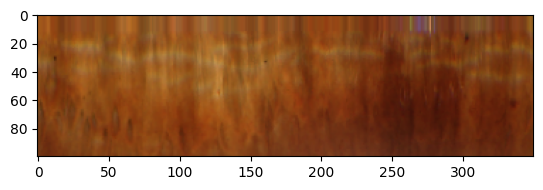

In [13]:
# Проверка одного изображения из выборки
plt.imshow(train_generator[1][0][2])
plt.show()

In [14]:
# Функция рисования образцов изображений из заданной выборки

def show_batch(batch,                # батч с примерами
               img_range=range(8),  # диапазон номеров картинок
               figsize=(25, 8),      # размер полотна для рисования одной строки таблицы
               columns=5             # число колонок в таблице
               ):

    for i in img_range:
        ix = i % columns
        if ix == 0:
            fig, ax = plt.subplots(1, columns, figsize=figsize)
        class_label = np.argmax(batch[1][i])
        ax[ix].set_title(CLASS_LIST[class_label])
        ax[ix].imshow(batch[0][i])  
        ax[ix].axis('off')
        plt.tight_layout()

    plt.show()

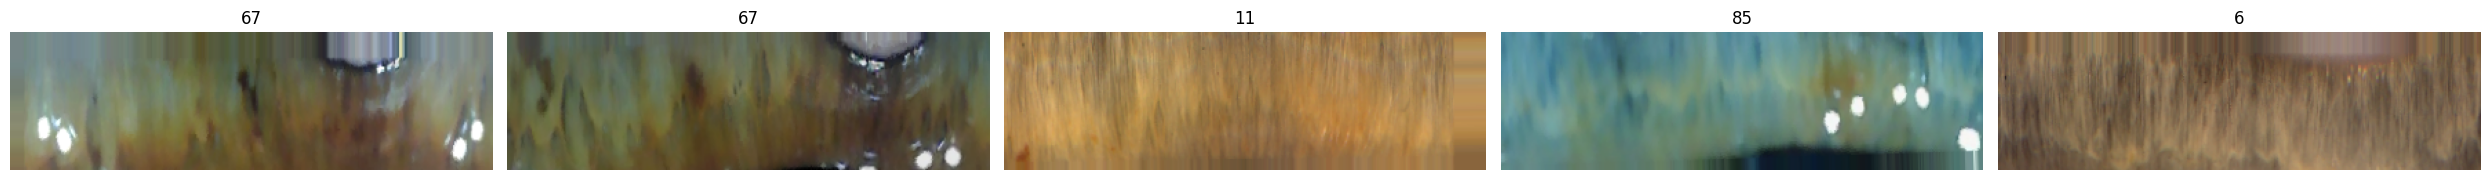

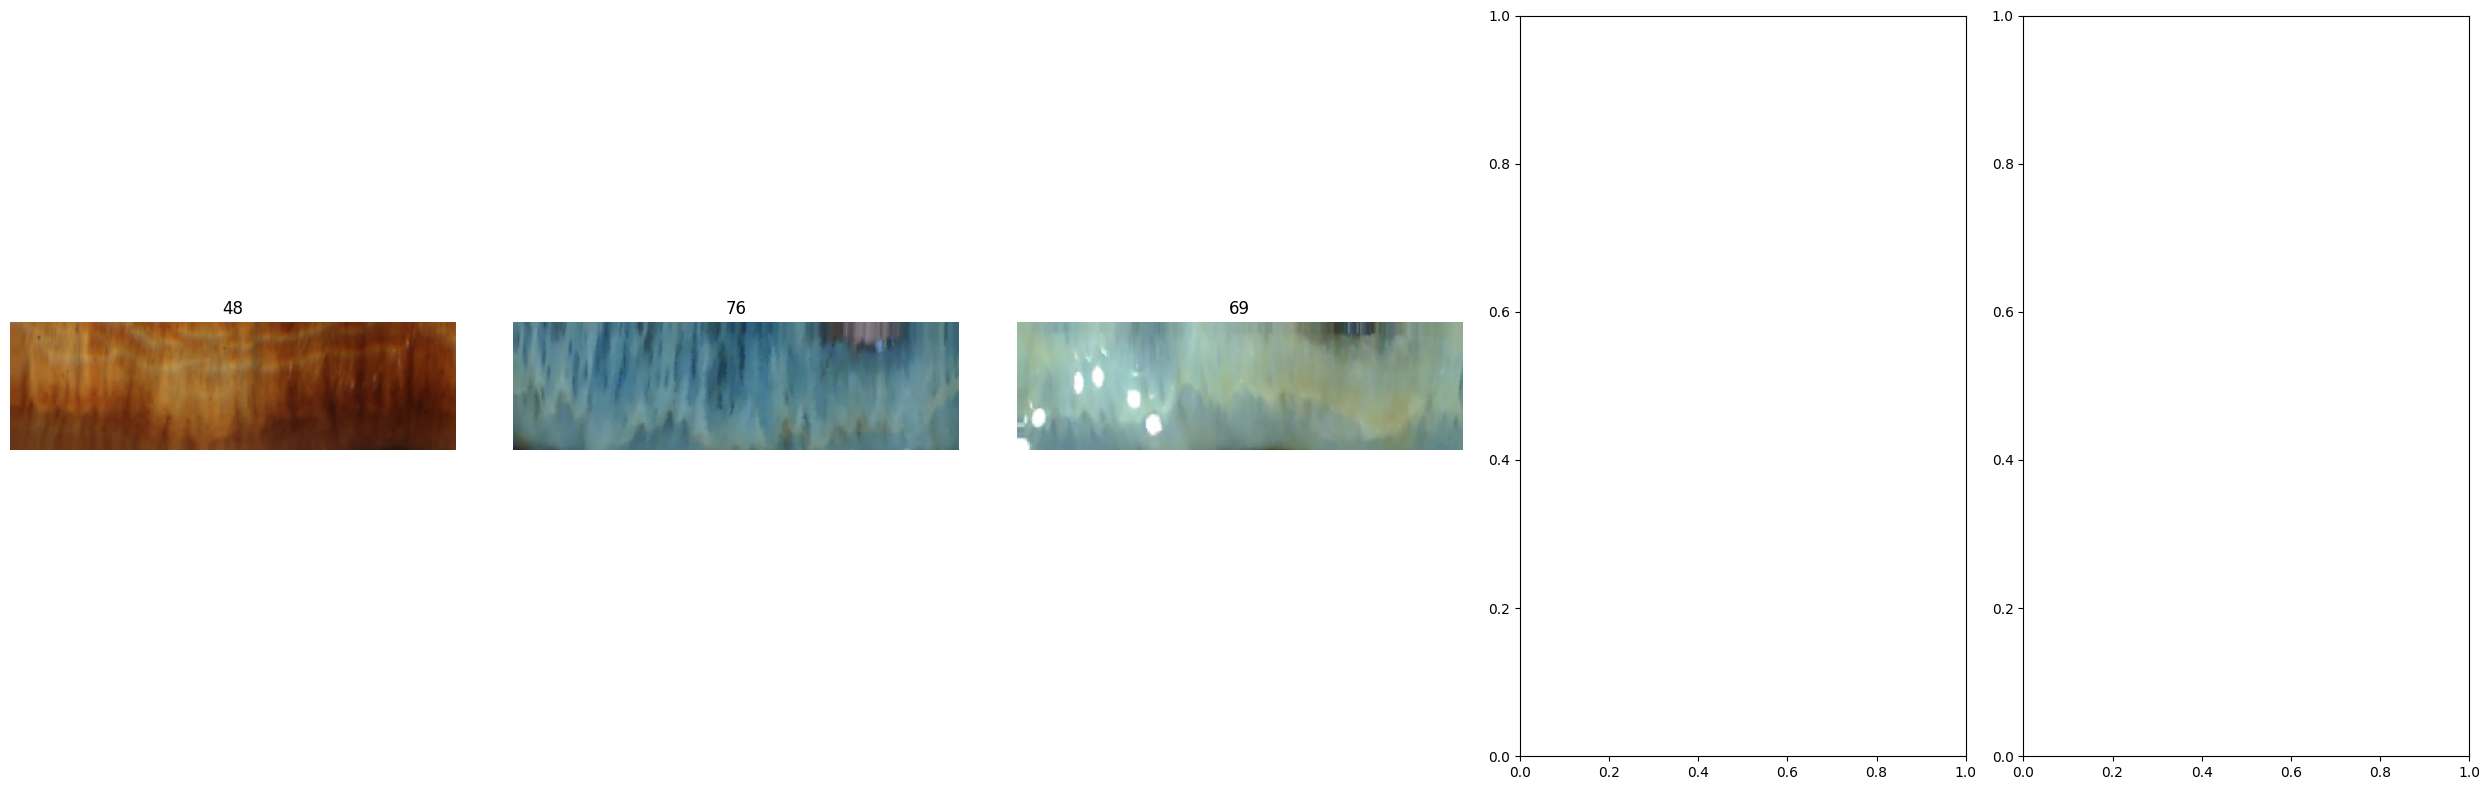

In [15]:
# Вывод примеров из 0-го батча train_generator
show_batch(train_generator[0])

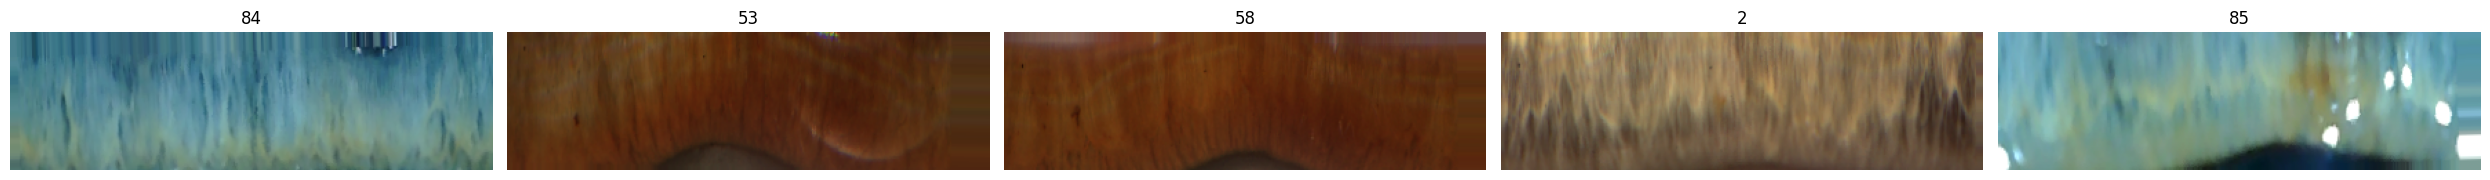

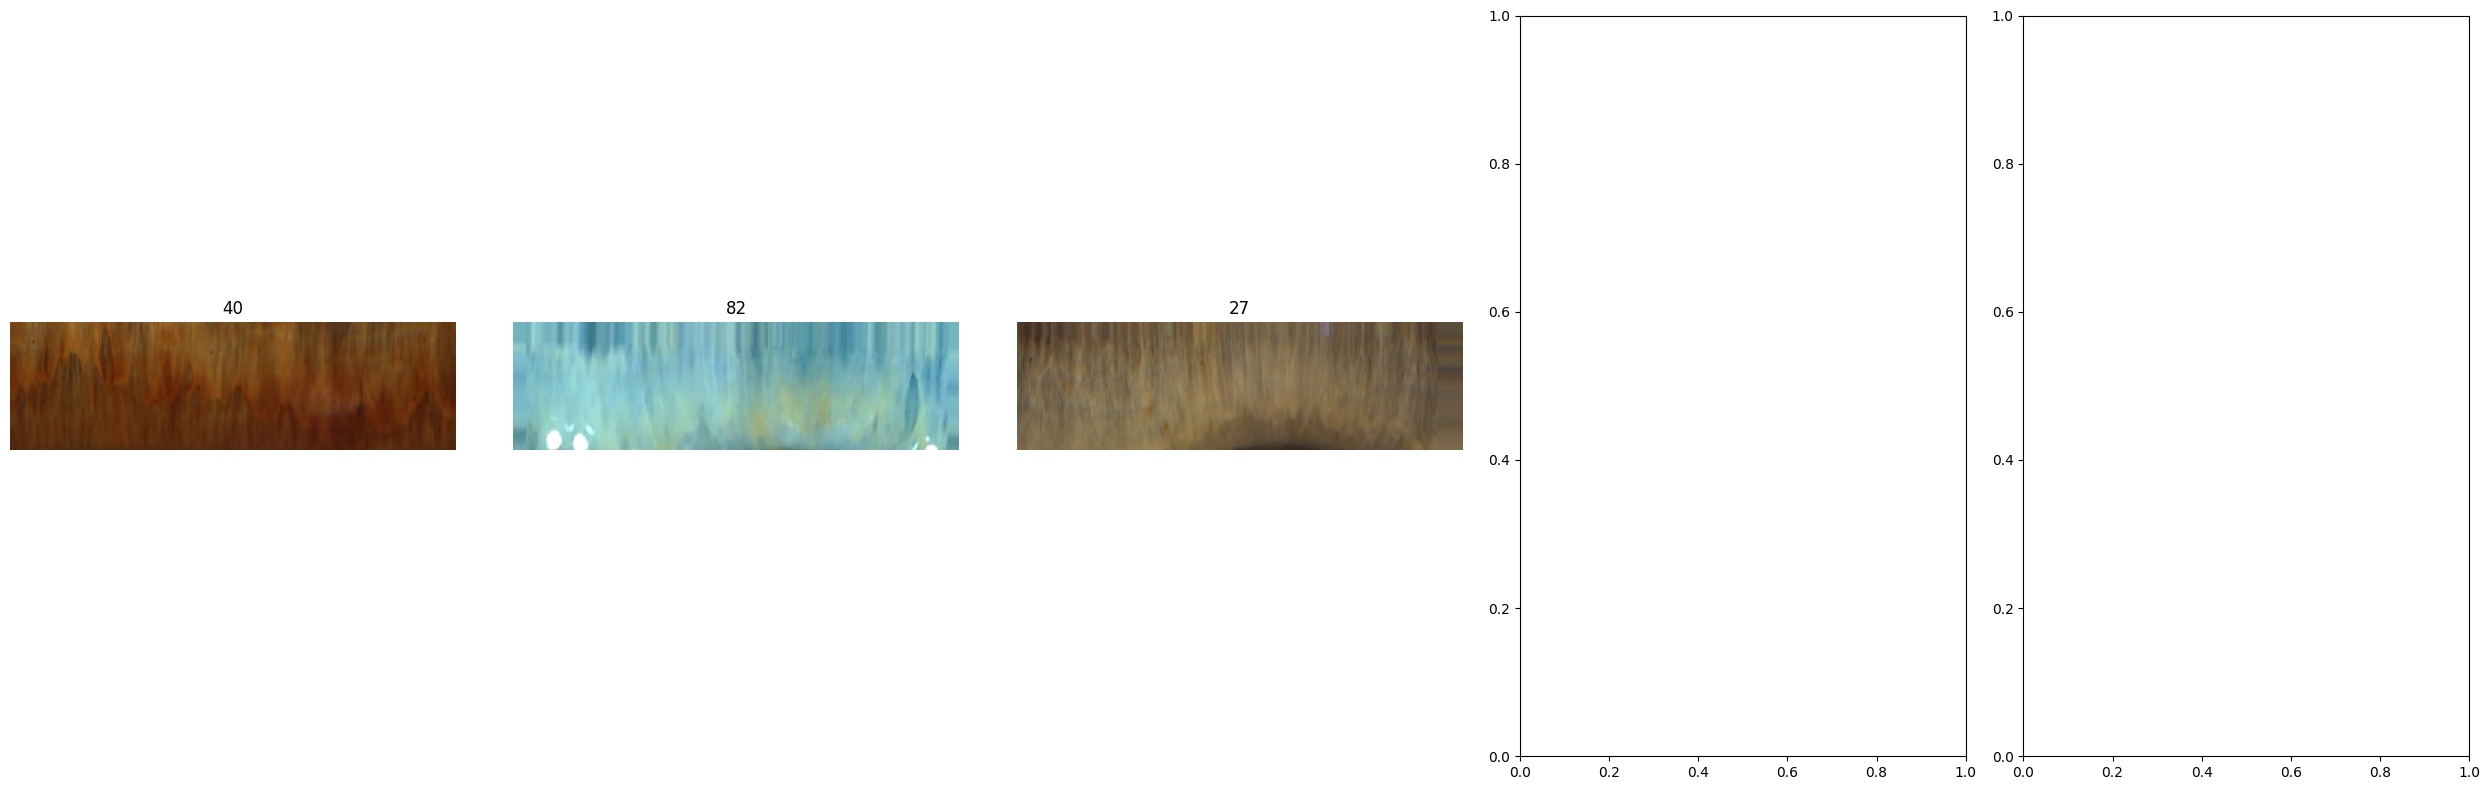

In [16]:
# Вывод примеров из 0-го батча validation_generator
show_batch(validation_generator[0])

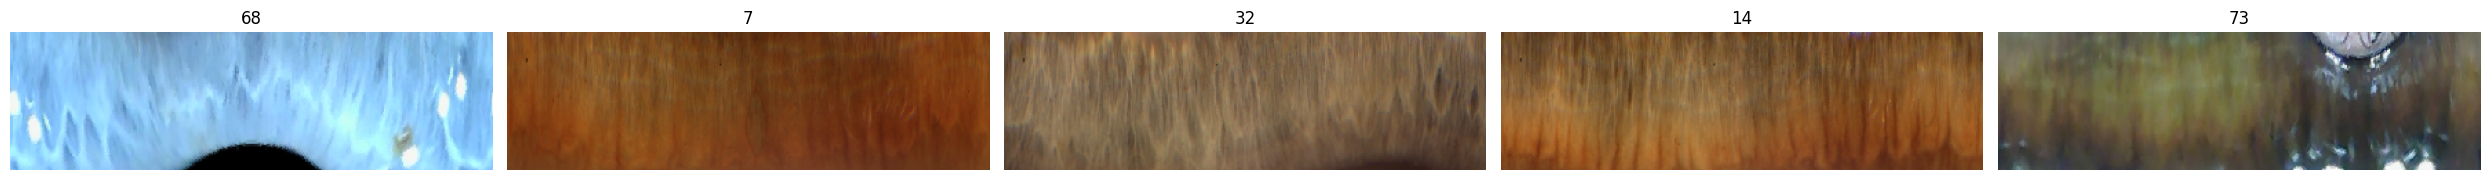

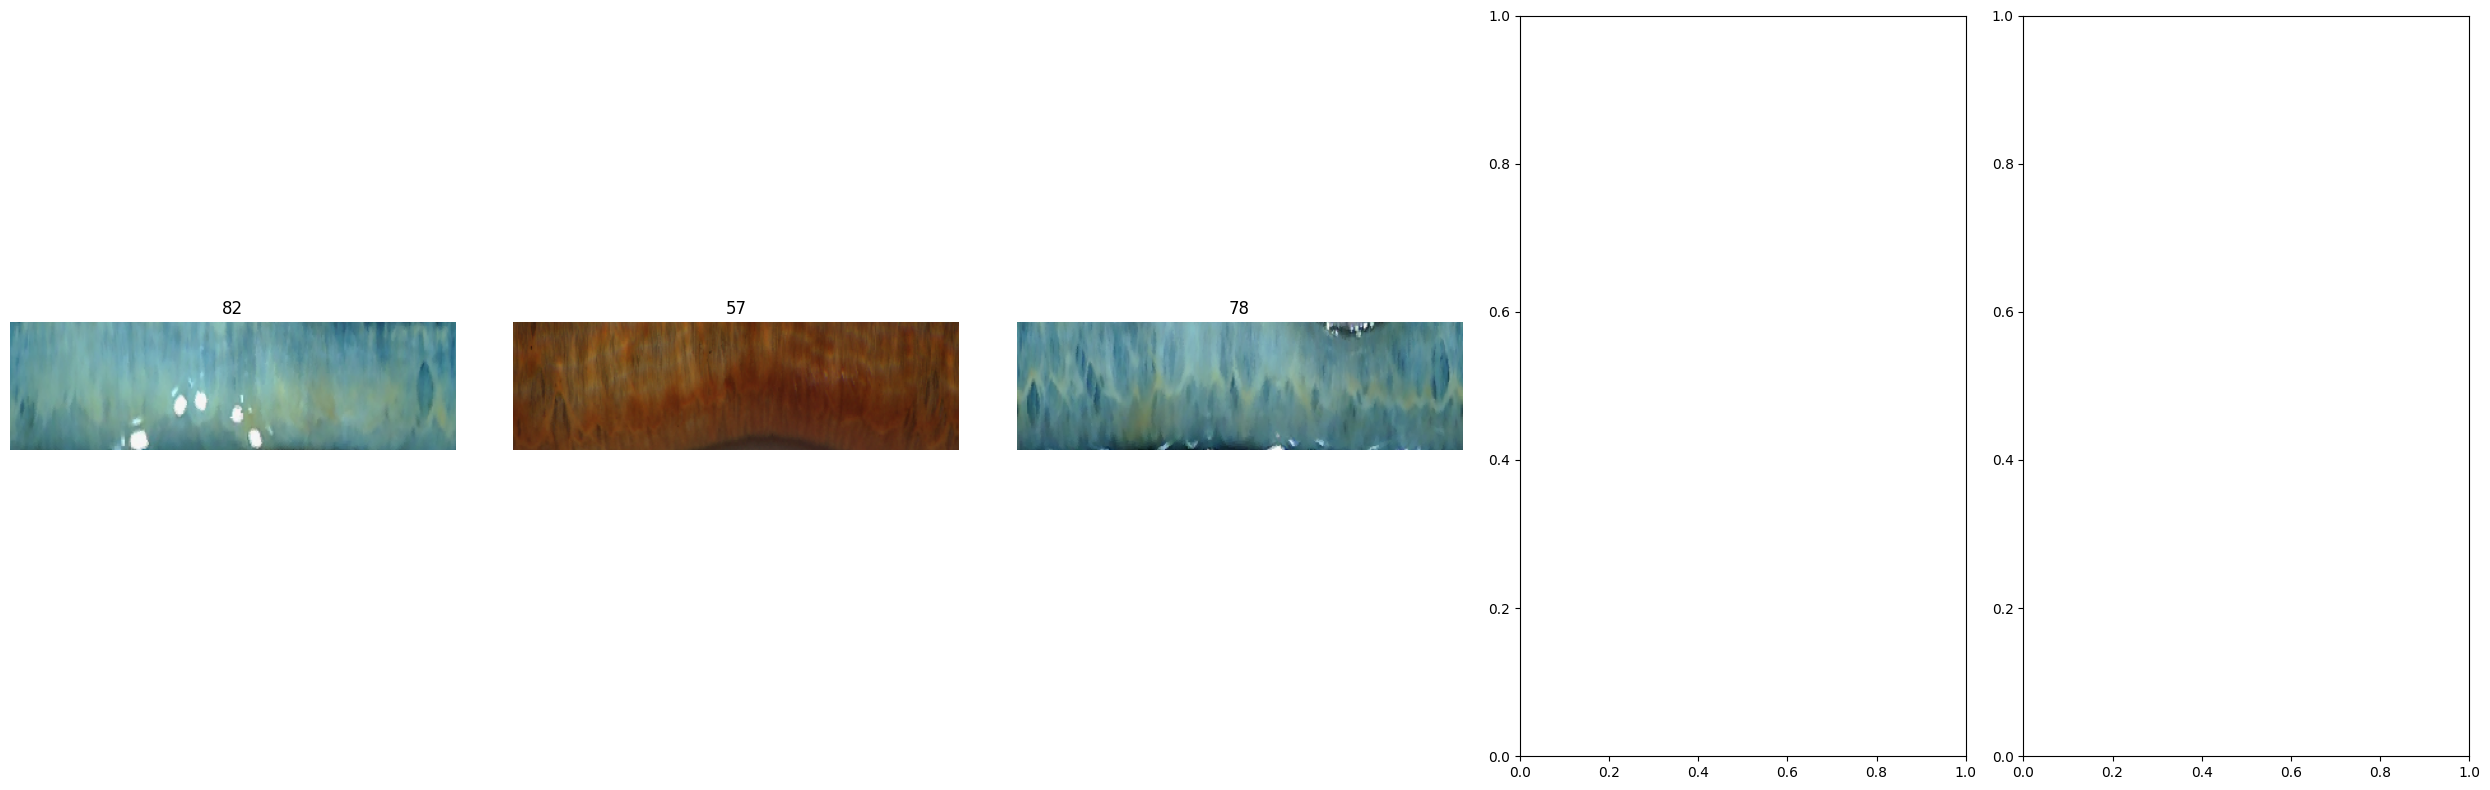

In [17]:
# Вывод примеров из 0-го батча validation_generator
show_batch(test_generator[0])

# Определим функцию компиляции и обучения модели

In [18]:
# Функция компиляции и обучения модели нейронной сети
# По окончанию выводит графики обучения

def compile_train_model(model,                  # модель нейронной сети
                        train_data,             # обучающие данные
                        val_data,               # проверочные данные
                        optimizer=OPTIMIZER,    # оптимизатор
                        epochs=EPOCHS,          # количество эпох обучения
                        batch_size=BATCH_SIZE,  # размер батча
                        figsize=(20, 5)):       # размер полотна для графиков

    # Компиляция модели
    model.compile(optimizer=optimizer, 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])

    # Вывод сводки
    model.summary()

    # Обучение модели с заданными параметрами
    history = model.fit(train_data,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=val_data)

    # Вывод графиков точности и ошибки
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    fig.suptitle('График процесса обучения модели')
    ax1.plot(history.history['accuracy'], 
               label='Доля верных ответов на обучающем наборе')
    ax1.plot(history.history['val_accuracy'], 
               label='Доля верных ответов на проверочном наборе')
    ax1.xaxis.get_major_locator().set_params(integer=True)
    ax1.set_xlabel('Эпоха обучения')
    ax1.set_ylabel('Доля верных ответов')
    ax1.legend()

    ax2.plot(history.history['loss'], 
               label='Ошибка на обучающем наборе')
    ax2.plot(history.history['val_loss'], 
               label='Ошибка на проверочном наборе')
    ax2.xaxis.get_major_locator().set_params(integer=True)
    ax2.set_xlabel('Эпоха обучения')
    ax2.set_ylabel('Ошибка')
    ax2.legend()
    plt.show()

# Определим функцию вывода результатов оценки модели

In [19]:
# Функция вывода результатов оценки модели на заданных данных

def eval_model(model, 
               x,                # данные для предсказания модели (вход)
               y_true,           # верные метки классов в формате OHE (выход)
               class_labels=[],  # список меток классов
               cm_round=3,       # число знаков после запятой для матрицы ошибок
               title='',         # название модели
               figsize=(10, 10)  # размер полотна для матрицы ошибок
               ):
    # Вычисление предсказания сети
    y_pred = model.predict(x)
    # Построение матрицы ошибок
    cm = confusion_matrix(np.argmax(y_true, axis=1),
                          np.argmax(y_pred, axis=1),
                          normalize='true')
    # Округление значений матрицы ошибок
    cm = np.around(cm, cm_round)

    # Отрисовка матрицы ошибок
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_title(f'Нейросеть {title}: матрица ошибок нормализованная', fontsize=18)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(ax=ax)
    ax.images[-1].colorbar.remove()       # Стирание ненужной цветовой шкалы
    fig.autofmt_xdate(rotation=45)        # Наклон меток горизонтальной оси
    plt.xlabel('Предсказанные классы', fontsize=16)
    plt.ylabel('Верные классы', fontsize=16)
    plt.show()    

    print('-'*100)
    print(f'Нейросеть: {title}')

    # Для каждого класса:
    for cls in range(len(class_labels)):
        # Определяется индекс класса с максимальным значением предсказания (уверенности)
        cls_pred = np.argmax(cm[cls])
        # Формируется сообщение о верности или неверности предсказания
        msg = 'ВЕРНО :-)' if cls_pred == cls else 'НЕВЕРНО :-('
        # Выводится текстовая информация о предсказанном классе и значении уверенности
        print('Класс: {:<20} {:3.0f}% сеть отнесла к классу {:<20} - {}'.format(class_labels[cls],
                                                                               100. * cm[cls, cls_pred],
                                                                               class_labels[cls_pred],
                                                                               msg))

    # Средняя точность распознавания определяется как среднее диагональных элементов матрицы ошибок
    print('\nСредняя точность распознавания: {:3.0f}%'.format(100. * cm.diagonal().mean()))

In [20]:
# Совместная функция обучения и оценки модели нейронной сети

def compile_train_eval_model(model,                    # модель нейронной сети
                             train_data,               # обучающие данные
                             val_data,                 # проверочные данные
                             test_data,                # тестовые данные
                             class_labels=CLASS_LIST,  # список меток классов
                             title='',                 # название модели
                             optimizer=OPTIMIZER,      # оптимизатор
                             epochs=EPOCHS,            # количество эпох обучения
                             batch_size=BATCH_SIZE,    # размер батча
                             graph_size=(20, 5),       # размер полотна для графиков обучения
                             cm_size=(10, 10)          # размер полотна для матрицы ошибок
                             ):

    # Компиляция и обучение модели на заданных параметрах
    # В качестве проверочных используются тестовые данные
    compile_train_model(model, 
                        train_data,
                        val_data,
                        optimizer=optimizer,
                        epochs=epochs,
                        batch_size=batch_size,
                        figsize=graph_size)

    # Вывод результатов оценки работы модели на тестовых данных
    eval_model(model, test_data[0][0], test_data[0][1], 
               class_labels=class_labels, 
               title=title,
               figsize=cm_size)

# Создадим модель

In [21]:
# Создание последовательной модели
model_conv = Sequential()

# Первый сверточный слой
model_conv.add(Conv2D(256, (3, 3), padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)))
model_conv.add(BatchNormalization())

# Второй сверточный слой
model_conv.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model_conv.add(MaxPooling2D(pool_size=(3, 3)))

# Третий сверточный слой
model_conv.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model_conv.add(BatchNormalization())
model_conv.add(Dropout(0.2))

# Четвертый сверточный слой
model_conv.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model_conv.add(MaxPooling2D(pool_size=(3, 3)))
model_conv.add(Dropout(0.2))

# Пятый сверточный слой
model_conv.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
model_conv.add(BatchNormalization())

# Шестой сверточный слой
model_conv.add(Conv2D(1024, (3, 3), padding='same', activation='relu'))
model_conv.add(MaxPooling2D(pool_size=(3, 3)))
model_conv.add(Dropout(0.2))

# Слой преобразования многомерных данных в одномерные 
model_conv.add(Flatten())

# Промежуточный полносвязный слой
model_conv.add(Dense(2048, activation='relu'))

# Промежуточный полносвязный слой
model_conv.add(Dense(4096, activation='relu'))

# Выходной полносвязный слой с количеством нейронов по количесту классов
model_conv.add(Dense(CLASS_COUNT, activation='softmax')) 
     

# Запуск обучения модели

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 350, 256)     7168      
                                                                 
 batch_normalization (BatchN  (None, 100, 350, 256)    1024      
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 350, 256)     590080    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 33, 116, 256)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 33, 116, 256)      590080    
                                                                 
 batch_normalization_1 (Batc  (None, 33, 116, 256)     1

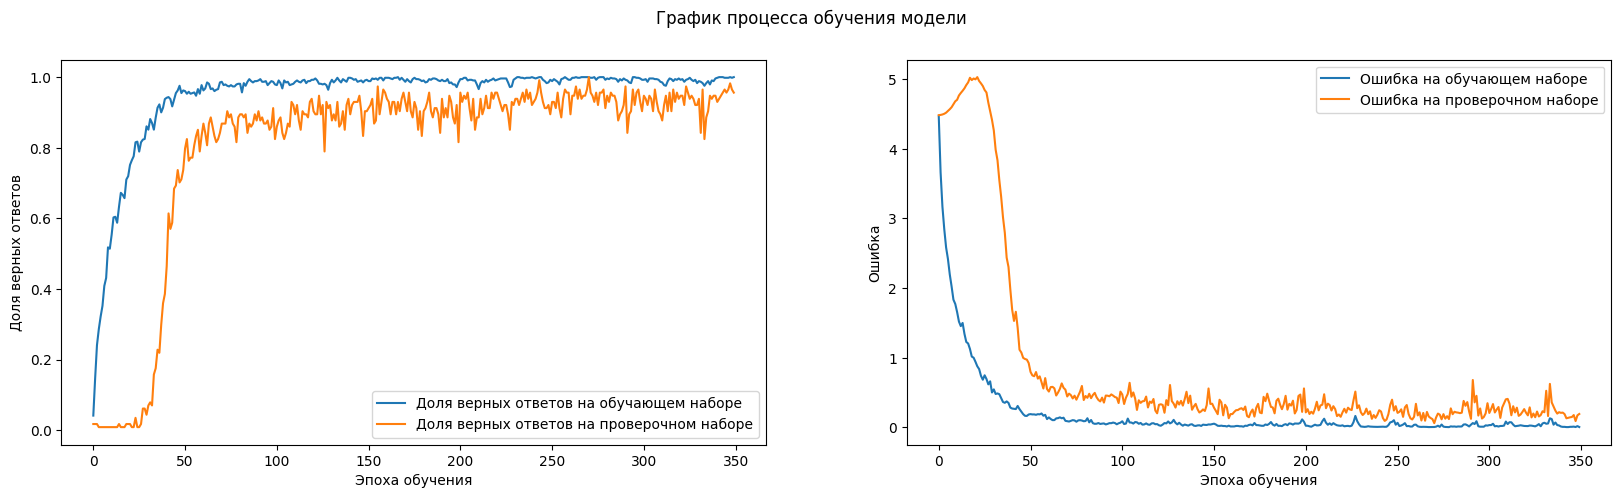

5/5 [==============================] - 4s 1s/step


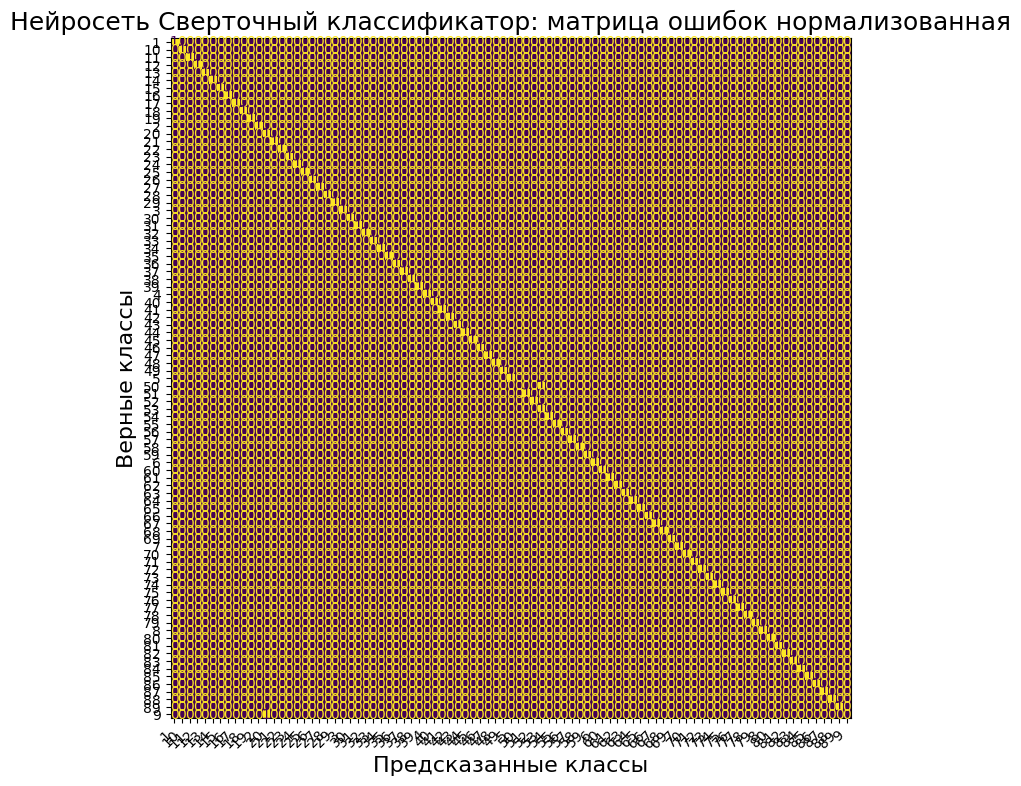

----------------------------------------------------------------------------------------------------
Нейросеть: Сверточный классификатор
Класс: 1                    100% сеть отнесла к классу 1                    - ВЕРНО :-)
Класс: 10                   100% сеть отнесла к классу 10                   - ВЕРНО :-)
Класс: 11                   100% сеть отнесла к классу 11                   - ВЕРНО :-)
Класс: 12                   100% сеть отнесла к классу 12                   - ВЕРНО :-)
Класс: 13                   100% сеть отнесла к классу 13                   - ВЕРНО :-)
Класс: 14                   100% сеть отнесла к классу 14                   - ВЕРНО :-)
Класс: 15                   100% сеть отнесла к классу 15                   - ВЕРНО :-)
Класс: 16                   100% сеть отнесла к классу 16                   - ВЕРНО :-)
Класс: 17                   100% сеть отнесла к классу 17                   - ВЕРНО :-)
Класс: 18                   100% сеть отнесла к классу 18              

In [22]:
# Обучение модели и вывод оценки ее работы на тестовых данных
compile_train_eval_model(model_conv,
                         train_generator,
                         validation_generator,
                         test_generator,
                         class_labels=CLASS_LIST,
                         title='Сверточный классификатор')

model_conv.save('/content/drive/MyDrive/IrisDataSource/model2305_1.h5')
